## Lecture 2: Reliability



In [13]:
import collections
import numpy as np
import pandas as pd
import seaborn
from sklearn.preprocessing import scale



Here is a path diagram - to see the code that generated it, look at PathDiagramExample.Rmd in this directory.


![title](path_diagram.png)

Generate some data from this model. We will treat the latent variables as normally distributed, with some degree of correlation.

In [14]:
def make_data(n_subjects=500,
              corr=0.5,
              error_var=0.5,
              scale_data=True,
              latent_seed=None,
              betavals=None):
    """
    create observed measurements from latent variables
    
    Parameters:
    ------------
    n_subjects: number of observations
    corr: population correlation between latent variables
    error_var: error variance
    scale_data: should we scale the variables?
    latent_seed: if set, will generate the same latent values each time (with different noise)
    """
    
    # create latent variables - multivariate normal with specified correlation

    if latent_seed is not None:
        np.random.seed(12345)
    latents = np.random.multivariate_normal(mean=[0, 0], 
                                            cov=[[1, corr], [corr, 1]],
                                            size=n_subjects)
    if scale_data:
        latents = scale(latents)

    df = pd.DataFrame(latents, columns=['impulsivity', 'impatience'])

    # create matrix to project latents into observed

    beta = pd.DataFrame(np.zeros((2, 4)), 
                        columns=['BIS', 'UPPS-P', 'Kirby', 'Bickel'],
                        index=df.columns)
    if betavals is None:
        betavals = {('impulsivity', 'BIS'): 1,
                    ('impulsivity', 'UPPS-P'): 1,
                    ('impatience', 'Bickel'): 1,
                    ('impatience', 'Kirby'): 1}
    for b in betavals:
        beta.loc[b[0], b[1]] = betavals[b]

    # create measurement noise, assume all variables have equal noise
    np.random.seed()  # ensure different noise each time
    measurement_noise = np.random.multivariate_normal(
        mean=[0, 0, 0, 0], 
        cov=np.eye(4)*error_var,
        size=n_subjects)

    # create observed data
    observed = df.dot(beta) + measurement_noise

    if scale_data:
        observed = (observed - observed.mean(axis=0))/observed.std(axis=0)

    df = result = pd.concat([df, observed], axis=1)

    return(df)

In [15]:
df = make_data(latent_seed=123345)
df.head()

,impulsivity,impatience,BIS,UPPS-P,Kirby,Bickel
0,-0.077887,0.377001,0.813375,0.667804,-0.607961,0.517711
1,0.720615,0.129221,0.135057,0.611868,-0.192631,0.587344
2,-2.440260,-1.062950,-3.065099,-2.564888,-0.011829,-0.481508
3,-0.238764,0.016280,0.245845,-0.128343,0.007986,0.464329
4,-1.318268,-0.088177,-2.123485,-0.950829,0.667464,-0.129361


Let's plot a heatmap of the correlations between latent and observed values

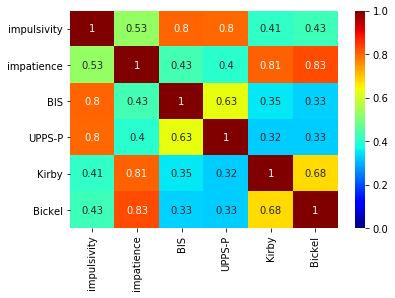

In [16]:
seaborn.heatmap(df.corr(), annot=True, vmin=0, cmap='jet')

What is the reliability of the measures for each latent?

In [17]:
rho_impulsivity = df[['BIS', 'UPPS-P']].corr().iloc[0, 1]
print('Impulsivity:', rho_impulsivity)

rho_impatience = df[['Kirby', 'Bickel']].corr().iloc[0, 1]
print('Impatience:', rho_impatience)

Impulsivity: 0.631599824472071
Impatience: 0.6781398253530805


## Attenuation

Error variance in our measures will *attenuate* the correlation between measures.  In this example, let's say that we wanted to estimate the correlation between impulsivity and impatience using the BIS and Kirby measures.  In this case, we know the true correlations of the latent variables:

In [18]:
rho_impulsivity_impatience = df[['impulsivity', 'impatience']].corr().iloc[0,1]
rho_impulsivity_impatience

0.5289766901235785

What do we see when we compare the two (noisy) measures?


In [19]:
rho_BIS_Kirby = df[['BIS', 'Kirby']].corr().iloc[0,1]
rho_BIS_Kirby

0.35182764291698565

We see here that the correlation between the measures is smaller than the correlation between their true scores.  We can correct for this attenuation using Spearman's formula:

$$
\rho_{T_Y, T_{Y'}} = \frac{\rho_{Y, Y'}}{\sqrt{\rho_Y \rho_{Y'}}}
$$

That is, the observed correlation is attenuated by the square root of the product of the reliabilities of the individual variables. We can see this with our measures:

In [20]:
rho_BIS_Kirby_corrected = rho_BIS_Kirby/np.sqrt(rho_impatience*rho_impulsivity)
rho_BIS_Kirby_corrected

0.537587712234753

We see that this is much closer to the true correlation between the latent variables.

## Test-retest reliability

Let's compare this what we see if we were to collect a new dataset with the same latent variables but different noise:


In [21]:
df_retest = make_data(latent_seed=123345)

retest_correlations = pd.Series(index=['BIS', 'UPPS-P', 'Kirby', 'Bickel'], 
                                dtype=float)

for i in retest_correlations.index:
    retest_correlations[i] = np.corrcoef(df[i], df_retest[i])[0,1]

retest_correlations

BIS       0.663373
UPPS-P    0.668290
Kirby     0.694190
Bickel    0.691768
dtype: float64

These are very close to the reliabilities that we estimated above by comparing the two tests - unsurprisingly, since all of these were generated by simply adding the same kind of noise to the latents. 

In the former case we used Pearson correlation to compute the reliability.  The Pearson coefficient assesses the degree to which the variables are linearly related, but doesn't penalize for different means or slope other than one.  That it, it assesses how well the following model describes the data:

$$
y = slope * X + intercept
$$

In other cases, we might want to hold our measurements to a higher standard of consistency or agreement. The *intraclass correlation coefficient* is commonly used for this purpose. There are many different forms of the ICC - here we will focus on ICC(3,1), which is commonly used to assess retest reliability.

$$
ICC(3,1) = \frac{MS_{subjects} - MS_{error}}{MS_{subjects} + MS_{error}}
$$

for the specific version with two measurements for each subject.  

In [22]:
# adapted from https://github.com/nipy/nipype/blob/f2bbcc917899c98102bdeb84db61ea4b84cbf2f5/nipype/algorithms/icc.py#L29

def ICC_rep_anova(Y, verbose=True):
    '''
    the data Y are entered as a 'table' ie subjects are in rows and repeated
    measures in columns
    One Sample Repeated measure ANOVA
    Y = XB + E with X = [FaTor / Subjects]
    '''

    [nb_subjects, nb_conditions] = Y.shape
    dfc = nb_conditions - 1
    dfe = (nb_subjects - 1) * dfc
    dfr = nb_subjects - 1

    # Compute the repeated measure effect
    # ------------------------------------

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y)**2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(nb_conditions), np.ones((nb_subjects, 1)))  # sessions
    x0 = np.tile(np.eye(nb_subjects), (nb_conditions, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals**2).sum()

    residuals.shape = Y.shape

    MSE = SSE / dfe

    # Sum square session effect - between colums/sessions
    SSC = ((np.mean(Y, 0) - mean_Y)**2).sum() * nb_subjects
    MSC = SSC / dfc / nb_subjects

    session_effect_F = MSC / MSE

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    # ICC(3,1) = (mean square subjeT - mean square error) /
    #            (mean square subjeT + (k-1)*-mean square error)
    ICC = (MSR - MSE) / (MSR + dfc * MSE)

    e_var = MSE  # variance of error
    r_var = (MSR - MSE) / nb_conditions  # variance between subjects
    if verbose:
        print('ICC:', ICC)
        print('r:', np.corrcoef(Y.T)[0, 1])
    return ICC, r_var, e_var, session_effect_F, dfc, dfe

In [23]:
Y = pd.DataFrame({'orig':df['BIS'], 'retest': df_retest['BIS']})

_ = ICC_rep_anova(Y.values)
print('ICC:')

ICC: 0.6633728811708539
r: 0.6633728811708536
ICC:


In this case we see that the ICC is exactly the same as the Pearson correlation, because the values have the same variance. However, because the ICC uses a pooled variance whereas the Pearson R scales separately by the variance of each variable, the ICC will differ if the variances differ:

In [24]:
Y['retest'] = Y['retest'] * 2

_ = ICC_rep_anova(Y.values)

ICC: 0.530698304936683
r: 0.6633728811708536


## Internal consistency

In cases where we don't have multiple parallel measures of the same underlying construct, another alternative is to assess the internal consistency of the individual measurements on our single measure.


## Split-half reliability

